In [22]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score, accuracy_score
from sklearn.model_selection import cross_val_score
from sklearn.metrics import accuracy_score
from sklearn.datasets import make_classification


# Loading the Dataset

In [23]:
df = pd.read_csv('health_infrastructure.csv')
df.head()

,Country,Year,Hospital_density,gdp,Communicable_disease,Hospital_Expenditure,Total_Health_Expenditure,Injury Count,life_expectancy,Mortality,Population
0,Australia,2000,6.648,4.158450e+11,35.6,2.987,7.594,138.30,79.2,676.8,19028802.0
1,Australia,2001,6.656,3.793580e+11,53.3,3.024,7.678,141.76,79.6,667.5,19274701.0
2,Australia,2002,6.586,3.955730e+11,32.2,3.123,7.876,142.60,79.9,682.5,19495210.0
3,Australia,2003,6.521,4.674980e+11,29.3,3.157,7.881,143.47,80.2,668.3,19720737.0
4,Australia,2004,6.477,6.143260e+11,46.4,3.250,8.087,144.10,80.5,663.8,19932722.0


#### convert countries to numerical using one-hot-encoding

In [24]:
df = pd.get_dummies(df, columns=['Country'])

In [25]:
df.sort_values(by=["Country_Portugal"])

,Year,Hospital_density,gdp,Communicable_disease,Hospital_Expenditure,Total_Health_Expenditure,Injury Count,life_expectancy,Mortality,Population,...,Country_Portugal,Country_Romania,Country_Slovak Republic,Country_Slovenia,Country_Spain,Country_Sweden,Country_Switzerland,Country_Türkiye,Country_United Kingdom,Country_United States
0,2000,6.648,4.158450e+11,35.6,2.987,7.594,138.30,79.2,676.8,19028802.0,...,0,0,0,0,0,0,0,0,0,0
590,2022,1.624,3.010250e+11,14.5,3.642,9.002,272.46,81.2,648.3,19828563.0,...,0,0,0,0,0,0,0,0,0,0
591,2000,4.868,5.686580e+09,0.2,1.928,5.164,131.93,71.1,1317.3,1396985.0,...,0,0,0,0,0,0,0,0,0,0
592,2001,4.827,6.254650e+09,0.1,1.450,4.781,175.99,70.9,1333.9,1388115.0,...,0,0,0,0,0,0,0,0,0,0
593,2002,3.697,7.367976e+09,0.3,1.487,4.703,207.92,71.4,1330.7,1379350.0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
422,2001,2.152,1.216040e+11,10.4,3.165,8.628,548.80,77.2,1018.9,10362721.5,...,1,0,0,0,0,0,0,0,0,0
421,2000,2.187,1.186050e+11,10.6,3.281,8.601,580.40,76.8,1028.3,10289898.0,...,1,0,0,0,0,0,0,0,0,0
859,2022,2.316,2.519450e+11,0.0,4.591,10.624,365.20,81.5,1092.1,10444241.5,...,1,0,0,0,0,0,0,0,0,0
433,2012,2.178,2.162240e+11,8.3,3.892,9.654,362.40,80.6,1026.8,10531419.5,...,1,0,0,0,0,0,0,0,0,0


#### Checking the correlation of the target variable with the features to make sure they are independent of one another.

In [26]:
features = df.drop(["Hospital_density"], axis=1)
target_variable = df['Hospital_density']
features

,Year,gdp,Communicable_disease,Hospital_Expenditure,Total_Health_Expenditure,Injury Count,life_expectancy,Mortality,Population,Country_Australia,...,Country_Portugal,Country_Romania,Country_Slovak Republic,Country_Slovenia,Country_Spain,Country_Sweden,Country_Switzerland,Country_Türkiye,Country_United Kingdom,Country_United States
0,2000,4.158450e+11,35.6,2.987,7.594,138.30,79.2,676.8,19028802.0,1,...,0,0,0,0,0,0,0,0,0,0
1,2001,3.793580e+11,53.3,3.024,7.678,141.76,79.6,667.5,19274701.0,1,...,0,0,0,0,0,0,0,0,0,0
2,2002,3.955730e+11,32.2,3.123,7.876,142.60,79.9,682.5,19495210.0,1,...,0,0,0,0,0,0,0,0,0,0
3,2003,4.674980e+11,29.3,3.157,7.881,143.47,80.2,668.3,19720737.0,1,...,0,0,0,0,0,0,0,0,0,0
4,2004,6.143260e+11,46.4,3.250,8.087,144.10,80.5,663.8,19932722.0,1,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
892,2003,2.056700e+12,3.0,5.036,7.988,498.50,78.3,1026.4,59636662.0,0,...,0,0,0,0,0,0,0,0,1,0
893,2011,2.666400e+12,5.5,5.036,9.724,333.00,80.7,872.6,63285145.0,0,...,0,0,0,0,0,0,0,0,1,0
894,2006,2.709980e+12,4.5,5.036,8.475,434.50,79.3,940.7,60827067.0,0,...,0,0,0,0,0,0,0,0,1,0
895,2001,1.648770e+12,1.9,5.036,7.413,546.20,78.0,1022.4,59113016.0,0,...,0,0,0,0,0,0,0,0,1,0


In [27]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 897 entries, 0 to 896
Data columns (total 49 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Year                      897 non-null    int64  
 1   Hospital_density          897 non-null    float64
 2   gdp                       897 non-null    float64
 3   Communicable_disease      897 non-null    float64
 4   Hospital_Expenditure      897 non-null    float64
 5   Total_Health_Expenditure  897 non-null    float64
 6   Injury Count              897 non-null    float64
 7   life_expectancy           897 non-null    float64
 8   Mortality                 897 non-null    float64
 9   Population                897 non-null    float64
 10  Country_Australia         897 non-null    uint8  
 11  Country_Austria           897 non-null    uint8  
 12  Country_Belgium           897 non-null    uint8  
 13  Country_Bulgaria          897 non-null    uint8  
 14  Country_Ca

# Separating the features and target variable

In [28]:
X = features
y = target_variable

# Splitting the Data into Training and Testing Sets

In [29]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


# Modeling

## Linear Regression

In [44]:
model = LinearRegression()
model.fit(X_train, y_train)
lg_y_pred = model.predict(X_test)

lg_mae = mean_squared_error(y_test, lg_y_pred)
print(f"Mean Squared Error: {round(lg_mae, 3)}")

lg_r2 = r2_score(y_test, lg_y_pred)
print(f'R-squared: {round(lg_r2, 3)}')




Mean Squared Error: 0.518
R-squared: 0.963


In [31]:
lg_y_pred[:20]




array([1.76745051, 1.51886154, 2.29073092, 2.71444534, 2.87427679,
       2.18395377, 2.52946168, 1.63897669, 1.67807895, 4.66409426,
       4.74484718, 2.33069957, 3.90871989, 3.4371665 , 1.70073628,
       2.01668873, 1.28845898, 1.44201651, 3.5379808 , 5.49546893])

##### Applying cross-validation to the MSE

In [32]:
cv_scores = cross_val_score(model, X, y, cv=5, scoring='neg_mean_squared_error')

# Converting negative MSE to positive and calculate the average
average_mse = -cv_scores.mean()

print(f'Cross-Validated MSE: {average_mse}')


Cross-Validated MSE: 8.603474046905612


## XGBOOST

In [33]:
xgb_model = xgb.XGBRegressor()
xgb_model.fit(X_train, y_train)
xgb_pred_y = xgb_model.predict(X_test)


In [34]:
xgb_pred_y[:10]

array([2.3083677, 1.4154005, 2.3559556, 1.5770807, 2.9732125, 2.393937 ,
       3.0988016, 2.0636795, 1.7391107, 4.2825527], dtype=float32)

#### XGBoost MsE and R-squared

In [35]:


mse_xgb = mean_squared_error(y_test, xgb_pred_y)
r2_xgb = r2_score(y_test, xgb_pred_y)
print(f"Mean Squared Error: {round(mse_xgb, 3)}")
print(f'R-squared: {round(r2_xgb, 3)}')

Mean Squared Error: 0.062
R-squared: 0.996


## Random Forest

In [36]:

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score

rf_regressor = RandomForestRegressor(n_estimators=100, random_state=42)
rf_regressor.fit(X_train, y_train)
predictions = rf_regressor.predict(X_test)
rf_mse = mean_squared_error(y_test, predictions)
rf_r2 = r2_score(y_test, predictions)
print(f"Mean Squared Error: {round(rf_mse,3)}")
print(f"R^2 Score: {round(rf_r2,3)}")


Mean Squared Error: 0.077
R^2 Score: 0.995


## Decision Tree

In [37]:
from sklearn.tree import DecisionTreeRegressor

model = DecisionTreeRegressor(random_state=42)
model.fit(X_train, y_train)
predictions = model.predict(X_test)

# Evaluate the model
dt_mse = mean_squared_error(y_test, predictions)
dt_r2 = r2_score(y_test, predictions)
print(f"Mean Squared Error: {round(dt_mse,3)}")
print(f"R^2 Score: {round(dt_r2,3)}")


Mean Squared Error: 0.177
R^2 Score: 0.987


In [38]:

model =["Linear Regression","XGBoost","Random Forest","Decision Tree"]
error=[0.518,0.062,0.077,0.177]
rsquare=[0.963,0.996,0.995,0.987]
error_table = {"Model":model,"Mean Squared Error":error, "R-Squared":rsquare}
df_errors =pd.DataFrame(error_table)
df_errors

,Model,Mean Squared Error,R-Squared
0,Linear Regression,0.518,0.963
1,XGBoost,0.062,0.996
2,Random Forest,0.077,0.995
3,Decision Tree,0.177,0.987


### XGBoost is performing better than all other models

In [39]:
xgb_pred_y


array([ 2.3083677 ,  1.4154005 ,  2.3559556 ,  1.5770807 ,  2.9732125 ,
        2.393937  ,  3.0988016 ,  2.0636795 ,  1.7391107 ,  4.2825527 ,
        4.278179  ,  2.2590573 ,  3.936893  ,  2.179815  ,  1.8550382 ,
        1.8951508 ,  0.9088622 ,  1.4394    ,  2.7806907 ,  7.0303006 ,
        1.6526259 ,  2.3118374 ,  2.625701  ,  1.7984604 , 22.378626  ,
        3.9280055 ,  3.1895342 ,  2.9918215 ,  1.5374386 ,  0.9956246 ,
        2.7273026 ,  4.5967593 ,  6.6218886 ,  2.5484219 ,  1.7460116 ,
        1.1205057 ,  3.4691136 ,  1.6924704 ,  2.9432333 ,  4.351745  ,
        4.3043056 ,  3.9384794 ,  1.4033632 ,  4.0881815 ,  1.3285546 ,
        1.9483345 ,  2.7436652 ,  3.7566    ,  1.717784  ,  5.511633  ,
        2.3969498 ,  2.2199407 ,  3.6700792 ,  1.9251708 ,  7.318956  ,
        1.8840151 ,  2.2400832 ,  2.3174736 ,  1.8276826 ,  2.1629539 ,
        2.5592287 ,  2.4611435 ,  2.950677  ,  3.7107434 ,  1.8496591 ,
        2.3404198 ,  2.450848  ,  1.8493772 ,  1.835914  ,  2.11

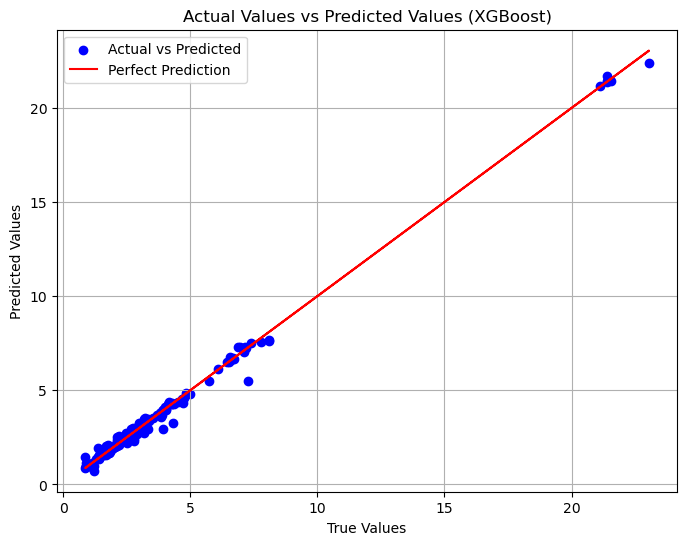

In [43]:
plt.figure(figsize=(8, 6))
plt.scatter(y_test, xgb_pred_y, color='blue', label='Actual vs Predicted')
plt.plot(y_test, y_test, color='red', label='Perfect Prediction')  # Diagonal line for perfect prediction
plt.title('Actual Values vs Predicted Values (XGBoost)')
plt.xlabel('True Values')
plt.ylabel('Predicted Values')
plt.legend()
plt.grid(True)
plt.show()
